# Nowcasting confidence in job security using Google Trends
## 1. Dataset presentation

In [1]:
import pandas as pd 
import numpy as np 
import datetime
import helpers
import matplotlib.pyplot as plt
FIGSIZE = (12, 6)

df = pd.read_csv('data/probability_dataset.csv', skiprows = 1).drop(columns = ['DK; NA', 'Unnamed: 11'])
df['Date'] = df.Year.apply(str) + "-" +  df.Month.apply(str)
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace = True)
df.index = pd.DatetimeIndex(df.index).to_period('M') # Set periodicity of the periods to monthly
df.drop(columns = ['Month', 'Year'], inplace = False) # Do not show month and year, but keep for aggregation

,0%,1-24%,25-49%,50%,51-74%,75-99%,100%,Mean
Date,,,,,,,,
2004-01,39,27,9,15,3,6,1,21.8
2004-02,42,28,8,11,3,5,2,20.2
2004-03,41,27,11,12,2,4,2,20.1
2004-04,37,29,10,13,3,5,2,21.9
2004-05,37,29,11,11,2,7,2,22.3
...,...,...,...,...,...,...,...,...
2020-06,41,27,12,11,2,4,3,20.7
2020-07,37,27,11,12,3,6,4,23.7
2020-08,38,30,11,10,2,5,3,21.4


Respondants were asked: 

"During the next 5 years, what do you think the chances are that you (or
your husband/wife) will lose a job that you wanted to keep ?". 

They were asked to answer an integer from 0 to 100. 

The dataset contains 8 columns. Columns 1 to 7 represent aggregates over certain percentage ranges. The last one is the overall average estimated probability the respondants gave. We will only look at the mean for now. 

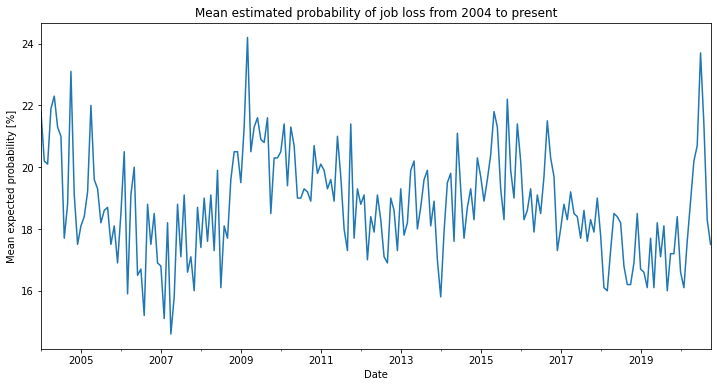

In [2]:
fig, ax = plt.subplots(1, 1, figsize = FIGSIZE) 
df['Mean'].plot()
ax.set_ylabel('Mean expected probability [%]')
ax.set_title('Mean estimated probability of job loss from 2004 to present')
plt.show()

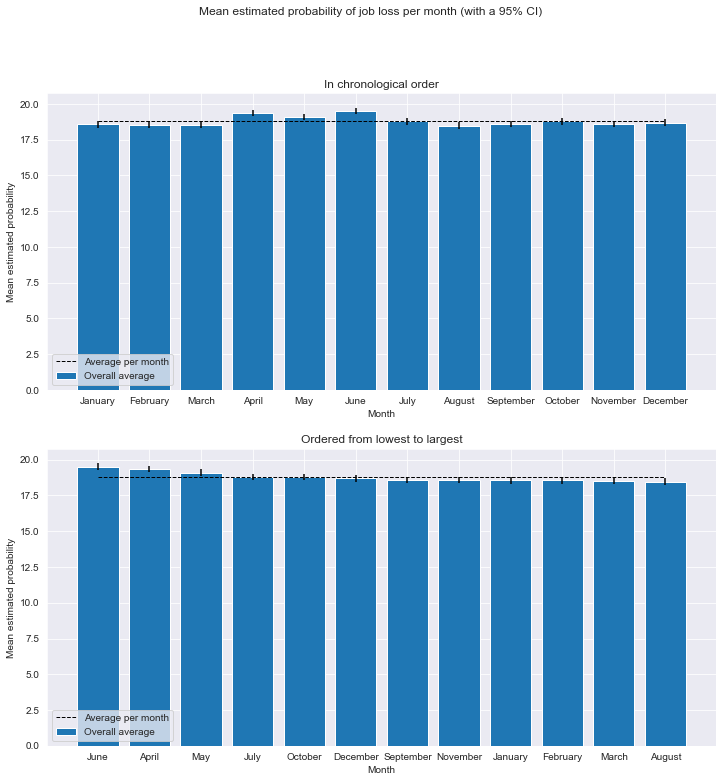

Estimated probability is typically above average in 
	April, May, June
and lower in 
	January, February, March, July, August, September, October, November, December.


In [153]:
months = [datetime.date(2000, m, 1).strftime('%B') for m in range(1, 13)]

monthly_df = df.set_index('Month')
y_error = np.zeros((2, 12))
for i in range(1, 13):
    l, h = helpers.bootstrap(monthly_df.Mean)
    m = np.mean(monthly_df.Mean)
    y_error[0,i-1] = m-l
    y_error[1,i-1] = h-m

ax[0].bar(x = months, height = monthly_mean, yerr = y_error)

fig, ax = plt.subplots(2, 1, figsize = (FIGSIZE[0], FIGSIZE[1]*2))

monthly_mean = df.groupby('Month').apply(np.mean)['Mean']
t = df.Mean.mean()

ax[0].bar(x = months, height = monthly_mean, yerr = y_error)

ax[0].set_xlabel('Month')
ax[0].set_ylabel('Mean estimated probability')
ax[0].set_title('In chronological order')
ax[0].plot([months[0], months[-1]], [t, t], "k--", linewidth = 1)
ax[0].legend(['Average per month', 'Overall average'])


sorted_order = np.argsort(-monthly_mean) # Sorted opposite to get descening order 
monthly_mean_sorted = np.array(monthly_mean)[sorted_order]
months_sorted = np.array(months)[sorted_order]


ax[1].bar(x = months_sorted, height = monthly_mean_sorted, yerr = y_error)

ax[1].set_xlabel('Month')
ax[1].set_ylabel('Mean estimated probability')
ax[1].set_title('Ordered from lowest to largest')
ax[1].plot([months_sorted[0], months_sorted[-1]], [t, t], "k--", linewidth = 1)
ax[1].legend(['Average per month', 'Overall average'])
fig.suptitle("Mean estimated probability of job loss per month (with a 95% CI)")
plt.show()

above = np.array(months)[monthly_mean > t]
below = np.array(months)[monthly_mean <= t]
print('Estimated probability is typically above average in \n\t{}\nand lower in \n\t{}.'.format(', '.join(above), ', '.join(below)))

## 2. Baseline model 
We build a baseline auto-regressive model. This is appropriate, because the time series we are modeling can be assumed to depend linearly on previous terms and on a stochastic term. The most reasonable assumption is that values taken on the previous month and the previous year are the most relevant. The dependence on the previous month allows to explain low frequency evolutions (i.e. the probability at a given month depends on the value at the previous month, meaning doesn't change too sharply in general, just like the economic situation usually changes gradually). The dependency on the previous year is important to account for seasonal changes; we have shown above that the probability has a seasonality, on average peaking in April.

Let $y$ denote the mean estimated probability of job loss.
Then, we model: 
$y_t = \beta_1 y_{t-1} + \beta_1 y_{t-1} + \epsilon_t \tag{1}$

## 